In [1]:
# System imports
import os
import sys

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

import warnings



In [2]:
# Load data
patient_info = pd.read_csv("hyperaktiv/patient_info.csv", sep=";")




In [3]:
patient_info.head()

,ID,SEX,AGE,ACC,ACC_TIME,ACC_DAYS,HRV,HRV_TIME,HRV_HOURS,CPT_II,...,HADS_D,MED,MED_Antidepr,MED_Moodstab,MED_Antipsych,MED_Anxiety_Benzo,MED_Sleep,MED_Analgesics_Opioids,MED_Stimulants,filter_$
0,1,0,3,1,16:00:00,6.0,1,11:00:00,21.0,0,...,2.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2,0,4,1,10:54:00,6.8,0,NaN,NaN,1,...,7.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,3,1,2,1,15:28:00,7.2,1,15:25:00,21.0,1,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4,1,3,0,NaN,NaN,1,16:55:00,22.0,1,...,6.0,1,1.0,NaN,NaN,1.0,NaN,1.0,NaN,0
4,5,1,1,1,14:24:00,5.9,1,16:00:00,12.0,1,...,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Plots 

- Age distribution
- Number of hours of HRV recordings
- Number of days of activity recordings


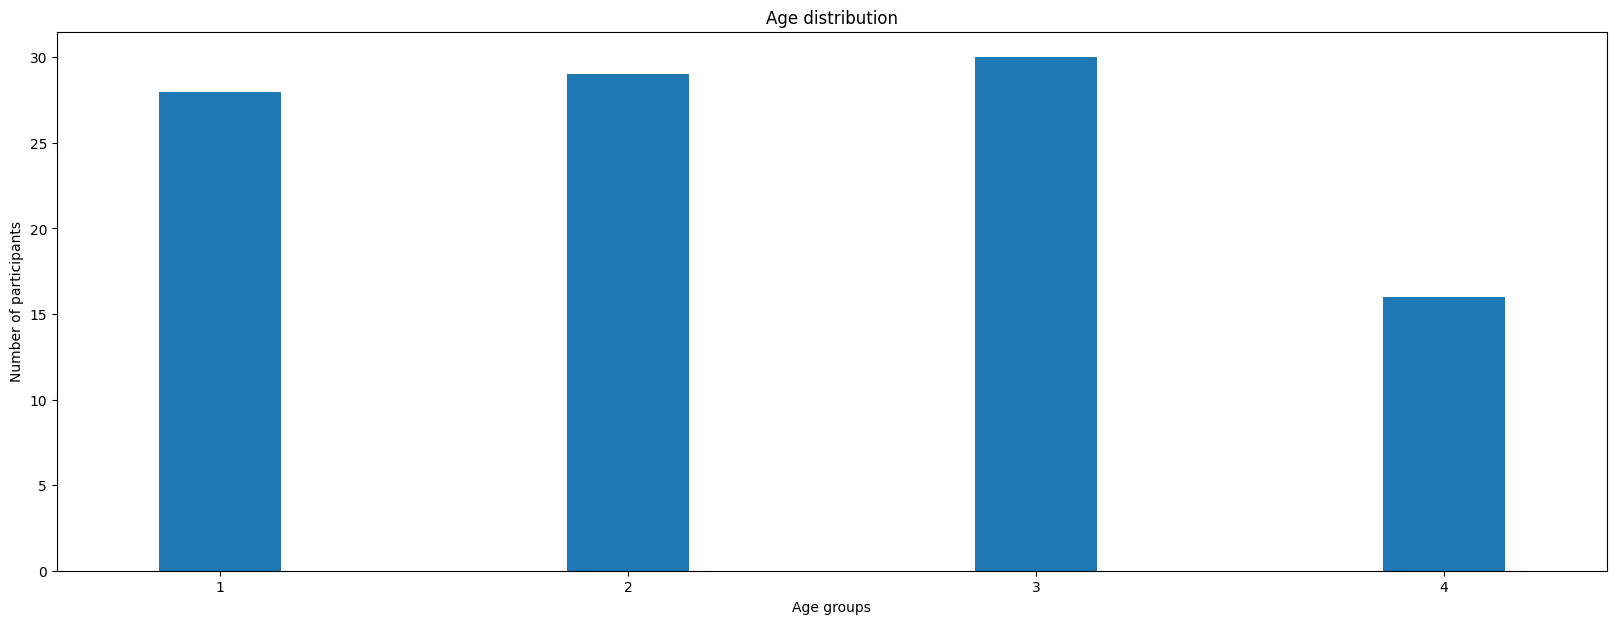

In [4]:
# Plot age distribution

plt.figure(figsize=(20,7))
plt.title("Age distribution")
plt.xlabel("Age groups")
plt.ylabel("Number of participants")

patient_info.AGE.value_counts().sort_index().plot(kind="bar", rot=0, width=0.3)
plt.show()

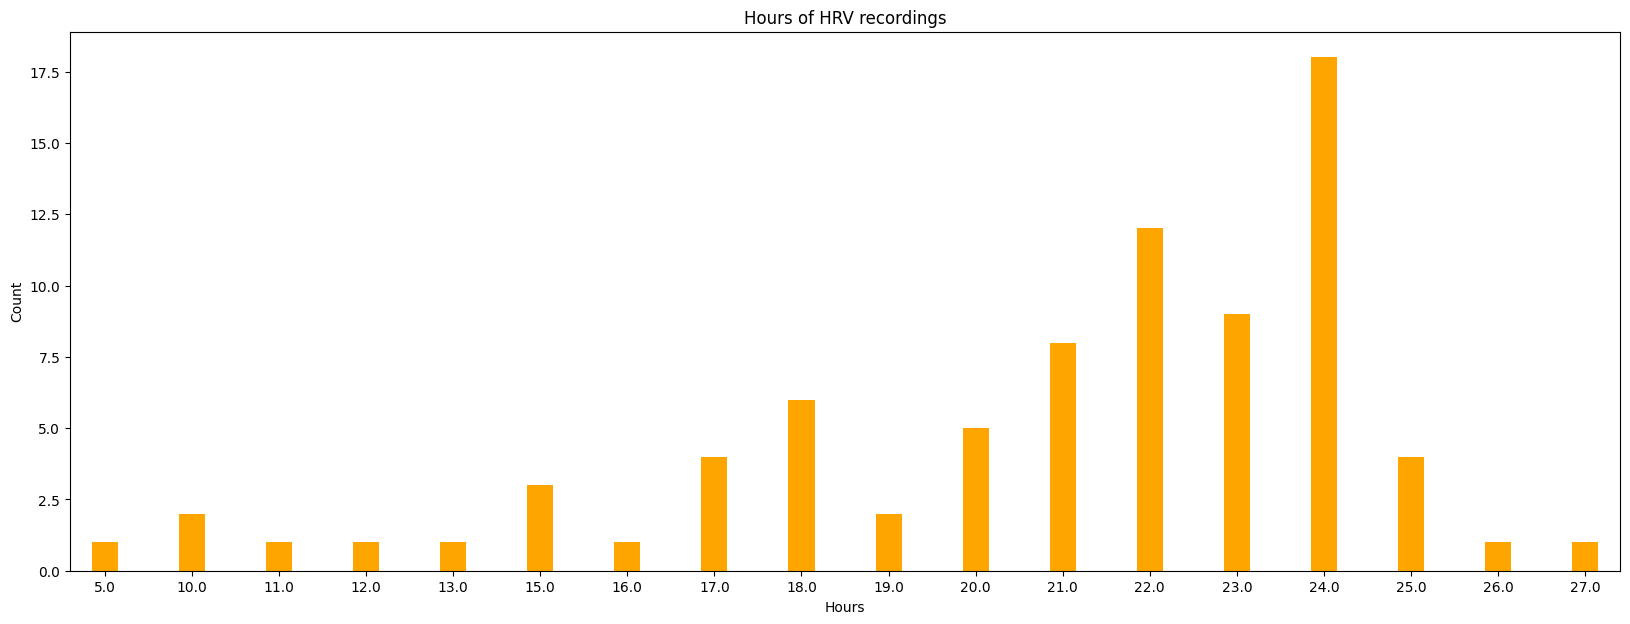

In [5]:
# Plot number of hours of HRV recordings

plt.figure(figsize=(20,7))
plt.title("Hours of HRV recordings")
plt.xlabel("Hours")
plt.ylabel("Count")

patient_info.HRV_HOURS.value_counts().sort_index().plot(kind="bar", rot=0, width=0.3, color="orange")
plt.show()

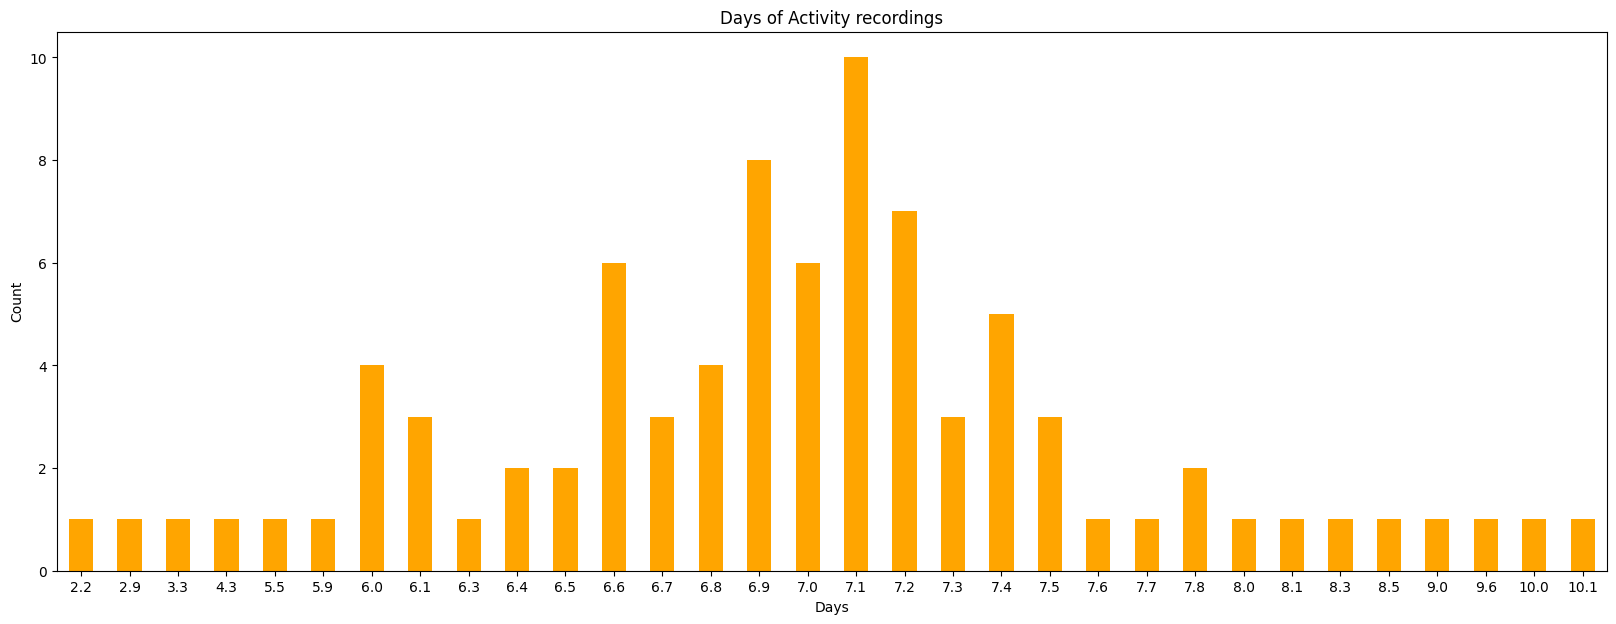

In [6]:
# Plot number of days of activity recordings

plt.figure(figsize=(20,7))
plt.title("Days of Activity recordings")
plt.xlabel("Days")
plt.ylabel("Count")

patient_info.ACC_DAYS.value_counts().sort_index().plot(kind="bar", rot=0, color="orange")
plt.show()

In [7]:
# Trying to make a plot that shows both the amount of hours recorded for control and ADHD groups, separated by gender...


# Plot number of days of activity recordings, across gender and group

#plt.figure(figsize= (20,7))
#plt.title("Days of Activity recordings")
#plt.xlabel("Days")
#plt.ylabel("Count")

#patient_info.ACC_DAYS.value_counts().sort(patient_info.SEX).plot(kind="bar", rot=0, color="purple")
#plt.show()

#Separate attempt

#plt.bar(patient_info.SEX, patient_info.ACC_DAYS, color="red")
#plt.bar(patient_info.SEX[7], patient_info.ACC_DAYS, color="blue")
#plt.title("Days of Activity recordings")
#plt.xlabel("Days")
#plt.ylabel("Count")
#plt.show()

Time domain analysis of HRV data

In [8]:
# Load HRV data

HRV_1 = pd.read_csv("hyperaktiv/hrv_data/patient_hr_1.csv", sep=";")

HRV_1.head()

# Try making a copy of the dataset and remove the first row, and see if it works with the interpolation further down.

,TIMESTAMP,HRV
0,2009-03-04 11:00:00.000,2294.92
1,2009-03-04 11:00:02.295,631.84
2,2009-03-04 11:00:02.927,624.02
3,2009-03-04 11:00:03.551,636.72
4,2009-03-04 11:00:04.188,625.98


In [9]:

print(HRV_1["TIMESTAMP"])

0         2009-03-04 11:00:00.000
1         2009-03-04 11:00:02.295
2         2009-03-04 11:00:02.927
3         2009-03-04 11:00:03.551
4         2009-03-04 11:00:04.188
                   ...           
107469    2009-03-05 08:07:30.918
107470    2009-03-05 08:07:31.590
107471    2009-03-05 08:07:32.260
107472    2009-03-05 08:07:32.931
107473    2009-03-05 08:07:33.593
Name: TIMESTAMP, Length: 107474, dtype: object


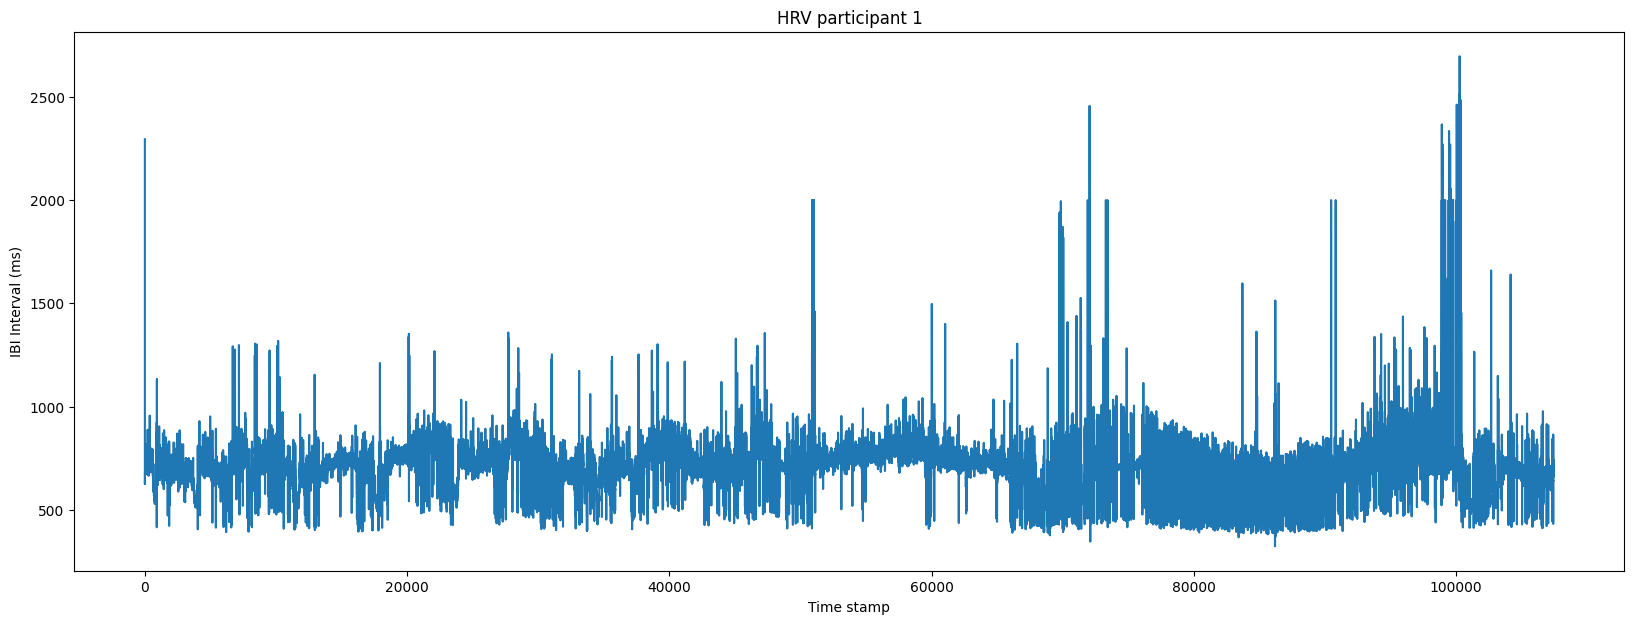

In [10]:
# Plot the HRV values and the timestamps.

plt.figure(figsize=(20, 7))
plt.title("HRV participant 1")
plt.xlabel("Time stamp")
plt.ylabel("IBI Interval (ms)")

plt.plot(HRV_1.HRV)
plt.show()

Check for outliers

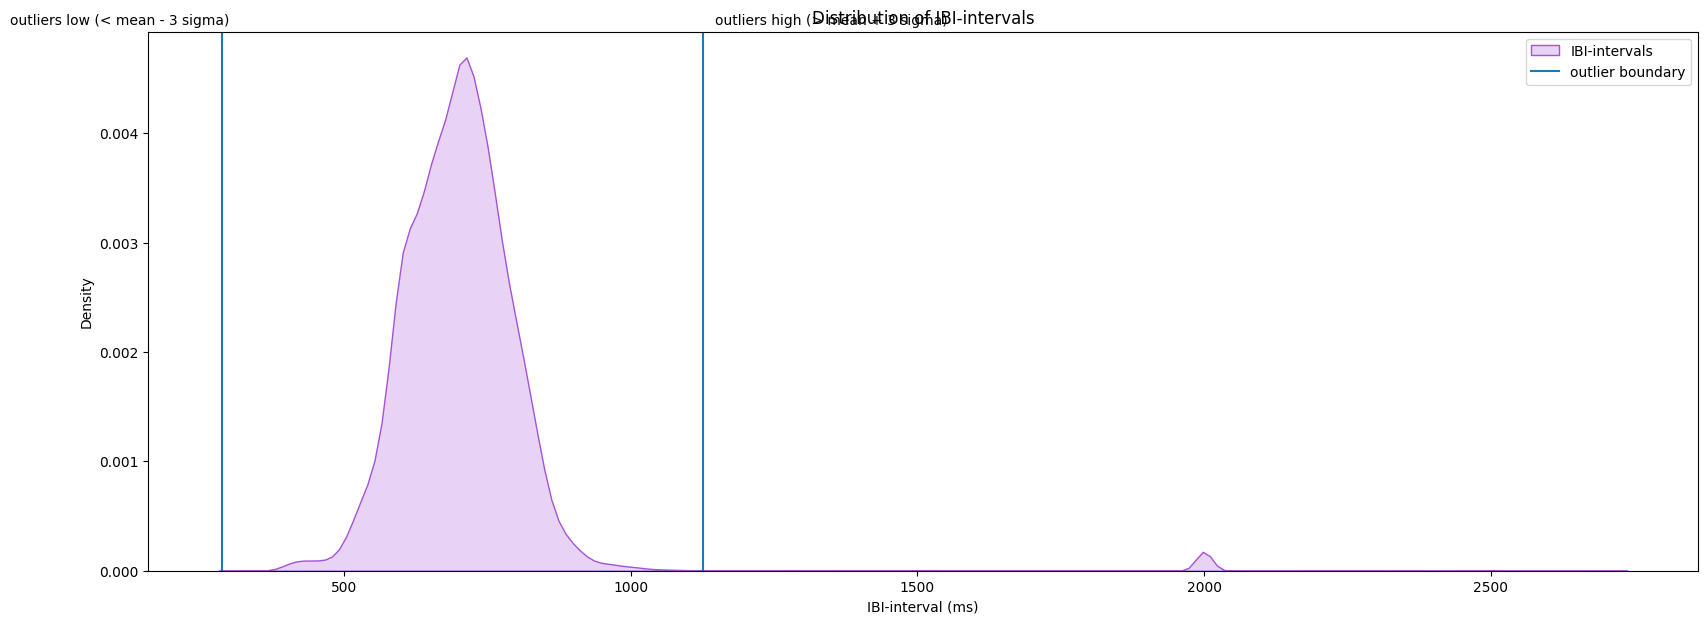

In [28]:
IBI = HRV_1.HRV

# Check for outliers (z-score above 3 or below -3)
plt.figure(figsize=(20, 7))
plt.title("Distribution of IBI-intervals")

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore FutureWarning 
    sns.kdeplot(IBI, label="IBI-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(IBI) - 3 * np.std(IBI)
outlier_high = np.mean(IBI) + 3 * np.std(IBI)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 370, 0.005, "outliers low (< mean - 3 sigma)") # Placement of text on plot
plt.text(outlier_high + 20, 0.005, "outliers high (> mean + 3 sigma)")

plt.xlabel("IBI-interval (ms)")
plt.ylabel("Density")

plt.legend()
plt.show()

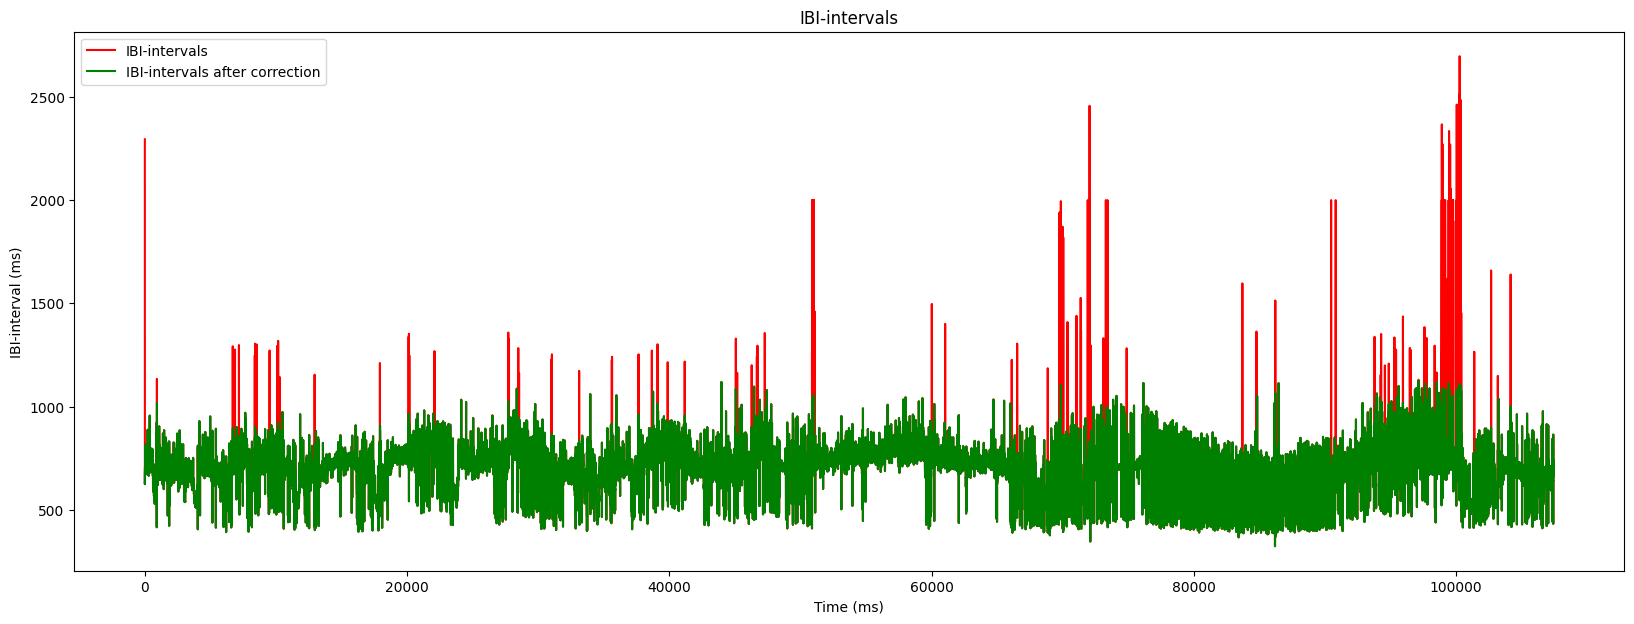

In [30]:
plt.figure(figsize=(20, 7))

IBI_corrected = IBI.copy()
IBI_corrected[np.abs(zscore(IBI)) > 3] = np.median(IBI)

plt.title("IBI-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("IBI-interval (ms)")

plt.plot(IBI, color="red", label="IBI-intervals")
plt.plot(IBI_corrected, color="green",  label="IBI-intervals after correction")
plt.legend()
plt.show()

Time domain analysis before and after correcting for outliers

In [37]:
# Time domain analysis of Participant 1

def timedomain(IBI):
    results = {}

    hr = 60000/IBI #Divide number of miliseconds in a whole minute with the IBI to find how many beats occur in one minute (BPM)
    
    results['Mean IBI (ms)'] = np.mean(IBI)
    results['STD IBI/SDNN (ms)'] = np.std(IBI)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(IBI)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(IBI))))
    results['NNxx'] = np.sum(np.abs(np.diff(IBI)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(IBI)) > 50)*1) / len(IBI)
    return results


print("Time domain metrics - IBI-intervals:")
for k, v in timedomain(IBI).items():
    print("- %s: %.2f" % (k, v))


print(" ")


def timedomain_cor(IBI_corrected):
    results = {}

    hr = 60000/IBI_corrected #Divide number of miliseconds in a whole minute with the IBI to find how many beats occur in one minute (BPM)
    
    results['Mean IBI (ms)'] = np.mean(IBI_corrected)
    results['STD IBI/SDNN (ms)'] = np.std(IBI_corrected)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(IBI_corrected)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(IBI_corrected))))
    results['NNxx'] = np.sum(np.abs(np.diff(IBI_corrected)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(IBI_corrected)) > 50)*1) / len(IBI_corrected)
    return results


print("Time domain metrics - Corrected IBI-intervals:")
for k, v in timedomain_cor(IBI_corrected).items():
    print("- %s: %.2f" % (k, v))




Time domain metrics - IBI-intervals:
- Mean IBI (ms): 707.65
- STD IBI/SDNN (ms): 139.83
- Mean HR (Kubios' style) (beats/min): 84.79
- Mean HR (beats/min): 86.93
- STD HR (beats/min): 12.52
- Min HR (beats/min): 22.24
- Max HR (beats/min): 185.62
- RMSSD (ms): 75.53
- NNxx: 6237.00
- pNNxx (%): 5.80
 
Time domain metrics - Corrected IBI-intervals:
- Mean IBI (ms): 697.77
- STD IBI/SDNN (ms): 86.39
- Mean HR (Kubios' style) (beats/min): 85.99
- Mean HR (beats/min): 87.38
- STD HR (beats/min): 11.47
- Min HR (beats/min): 53.38
- Max HR (beats/min): 185.62
- RMSSD (ms): 52.19
- NNxx: 6000.00
- pNNxx (%): 5.58


Frequency domain analysis - DO THIS AFTER REMOVING OUTLIERS

In [21]:
# Removing the first entry/row in the dataset because it is a very large value
IBI_1 = IBI.drop(index=0)

IBI_1.head()

1    631.84
2    624.02
3    636.72
4    625.98
5    632.81
Name: HRV, dtype: float64

In [22]:
# Frequency domain analysis of Participant 1

# Fourier Transformation requires evenly sampled data, and the time between each timestamp in the dataset is currently
# not even. This can be done by interpolating the data.

# Creating an interpolation function. We want 4 samples per second.
x = np.cumsum(IBI_1)/1000.0   # This turns ms to sec.
f = interp1d(x, IBI_1, kind= "cubic")

# Sample rate for interpolation and stepsize
fs = 4.0
steps = 1/fs

# Sampling from interpolation function
xx = np.arange(1, np.max(x), steps)
IBI_interpolated = f(xx)


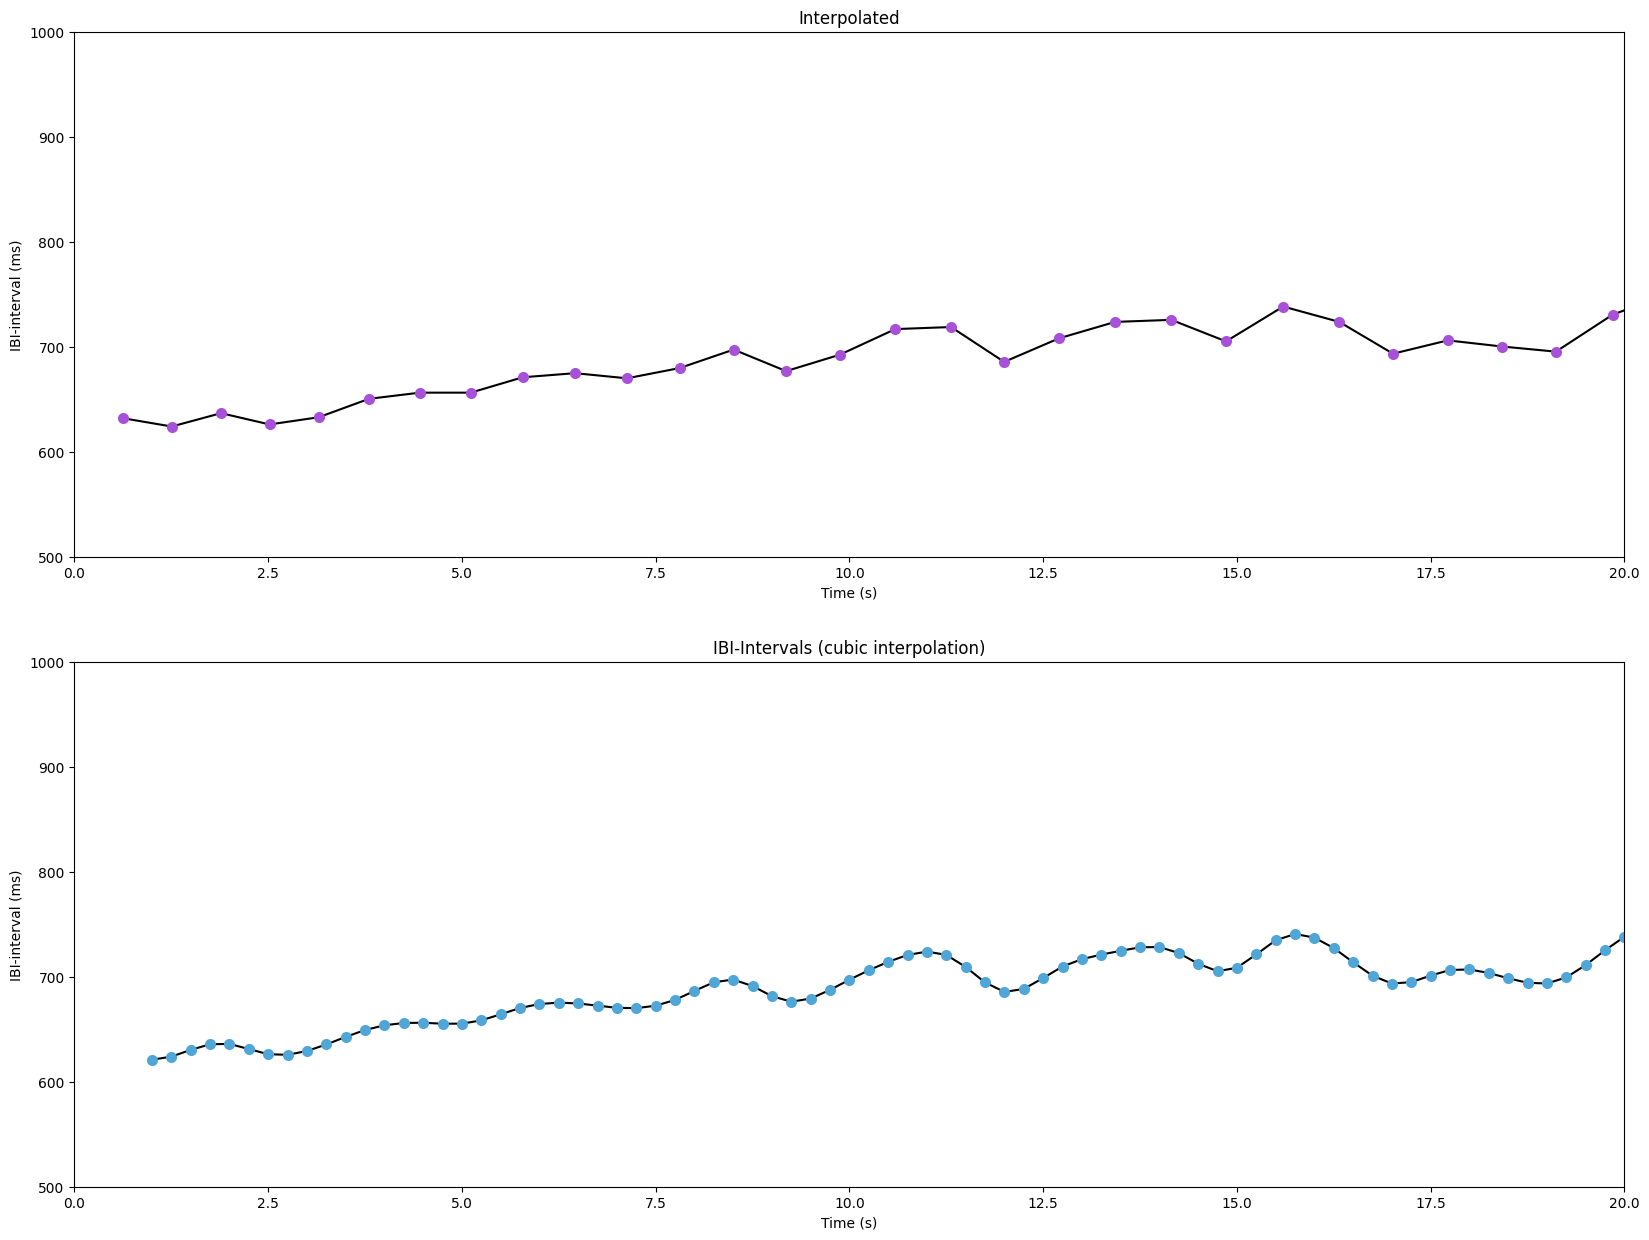

In [24]:
# Plot to see the interpolation
plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("IBI intervals")
plt.plot(x, IBI_1, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("IBI-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 20)
plt.gca().set_ylim(500, 1000)

plt.subplot(212)
plt.title("IBI-Intervals (cubic interpolation)")
plt.plot(xx, IBI_interpolated, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 20)
plt.gca().set_ylim(500, 1000)
plt.xlabel("Time (s)")
plt.ylabel("IBI-interval (ms)")
plt.show()

In [38]:
##### THIS SNIPPET IS ALSMOST ENTIRELY STOLEN, SHOULD I MAKE CHANGES IN IT?

def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=IBI_interpolated, fs=fs)
    
    '''
    Segment found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)  # Conditions for the different frequency bands
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)

  # calculate the power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum to get the total power
    total_power = vlf + lf + hf


     # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx


In [39]:
print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(IBI_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 1187.25
- Power LF (ms2): 1464.41
- Power HF (ms2): 1704.66
- Power Total (ms2): 4356.33
- LF/HF: 0.86
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.05
- Peak HF (Hz): 0.20
- Fraction LF (nu): 46.21
- Fraction HF (nu): 53.79


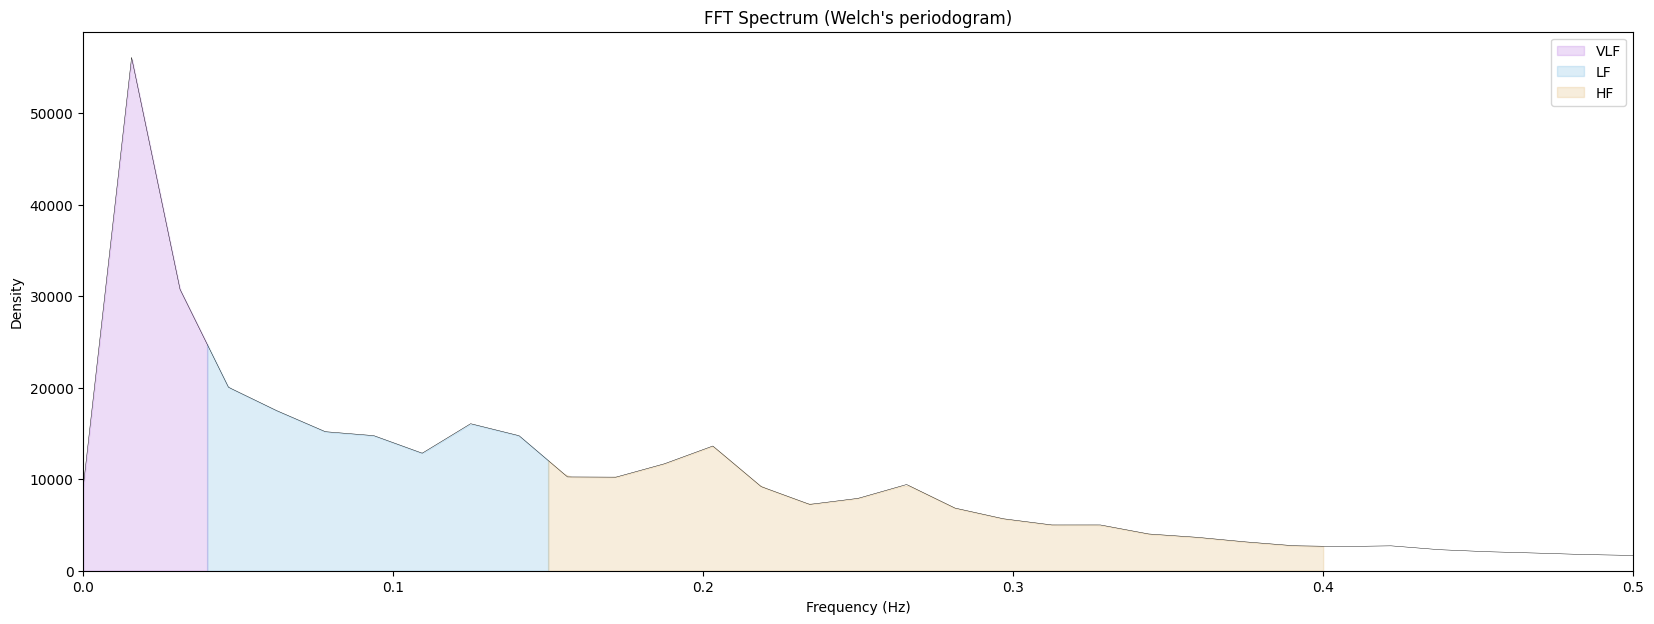

In [40]:
# Plot Welch periodogram

plt.figure(figsize=(20, 7))
plt.plot(fxx, pxx, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx, pxx)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

Non-linear Methods - THIS IS NOT WORKING. LOOK INTO IT AND FIND OUT WHY

SD1: 0.000 ms
SD2: 122.181 ms


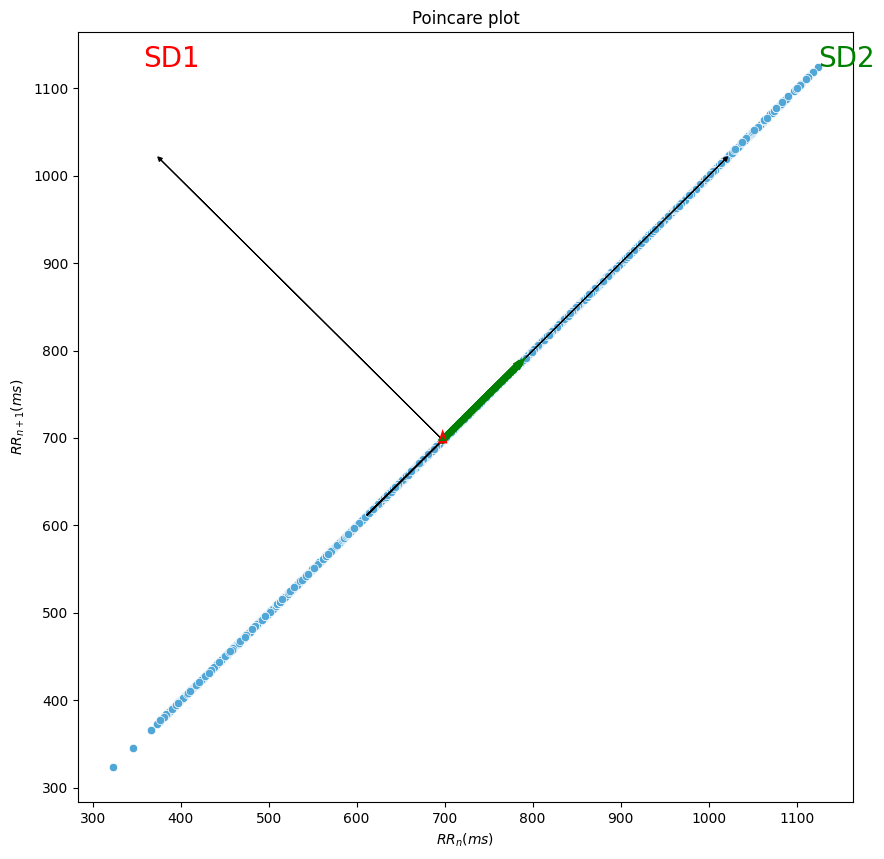

In [46]:
def plot_poincare(IBI_corrected):
    IBI_n = IBI_corrected[:-1]
    IBI_n1 = IBI_corrected[1:]

    sd1 = np.sqrt(0.5) * np.std(IBI_n1 - IBI_n)
    sd2 = np.sqrt(0.5) * np.std(IBI_n1 + IBI_n)

    m = np.mean(IBI_corrected)
    min_IBI = np.min(IBI_corrected)
    max_IBI = np.max(IBI_corrected)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=IBI_n, y=IBI_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)
    plt.gca().

    plt.arrow(m, m, (max_IBI-min_IBI)*0.4, (max_IBI-min_IBI)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_IBI-max_IBI)*0.4, (max_IBI-min_IBI)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)    
    plt.text(max_IBI, max_IBI, "SD2", fontsize=20, color="green")
    plt.text(m-(max_IBI-min_IBI)*0.4-20, max_IBI, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

sd1, sd2 = plot_poincare(IBI_corrected)
print("SD1: %.3f ms" % sd1)
print("SD2: %.3f ms" % sd2)

Activity data

In [ ]:
# Load activity data

ACT_1 = pd.read_csv("hyperaktiv/activity_data/patient_activity_01.csv", sep= ";")

ACT_1.head()